# Libraries

In [1]:
# get the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [2]:
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test.reshape(192,128))
  unscaled = scaler.inverse_transform(mat.reshape(192,128))
  return unscaled


In [3]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

# RF Regressor

## 6 monthly

In [4]:
# load datasets
data_06 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\6monthly_scaled100_avhrr_vhi_1981_2022.npy")
label_06 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/6monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
data_06_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/6monthly_scaledto1_avhrr_vhi_1981_2022.npy")
label_06_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\6monthly_scaledto1_avhrr_vhi_1981_2022_label.npy")
print(data_06.shape, label_06.shape, data_06_norm.shape, label_06_norm.shape)
## Splitting into train and test
np.max(data_06), np.min(data_06), np.max(data_06_norm), np.min(data_06_norm)


(525, 192, 128, 1) (525, 192, 128, 1) (525, 192, 128, 1) (525, 192, 128, 1)


(100.00000000000001, 0.0, 1.0, 0.0)

In [5]:
train_image = data_06_norm[:480]
train_label = label_06_norm[:480]
test_image = data_06_norm[480:]
test_label = label_06_norm[480:]
print(train_image.shape, train_label.shape, test_image.shape, test_label.shape)
data_train = data_06[:480]
label_train = label_06[:480]
data_test = data_06[480:]
label_test= label_06[480:]
print(data_train.shape, label_train.shape, data_test.shape, label_test.shape)
train_image_flattened = train_image.reshape(480,24576)
train_label_flattened = train_label.reshape(480,24576)
test_image_flattened = test_image.reshape(45,24576)
test_label_flattened = test_label.reshape(45,24576)

(480, 192, 128, 1) (480, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)
(480, 192, 128, 1) (480, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)


In [6]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=3,max_depth=2, verbose=2, n_jobs=-1)

# train model
forest.fit(train_image_flattened, train_label_flattened)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.5min finished


RandomForestRegressor(max_depth=2, n_estimators=3, n_jobs=-1, verbose=2)

In [8]:
predicted_RF_06 = forest.predict(test_image_flattened)
predicted_RF_06 = predicted_RF_06.reshape(45,192,128)
print(predicted_RF_06.shape)

(45, 192, 128)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.00093053916>>
0.027387281994163147 0.51693272058666


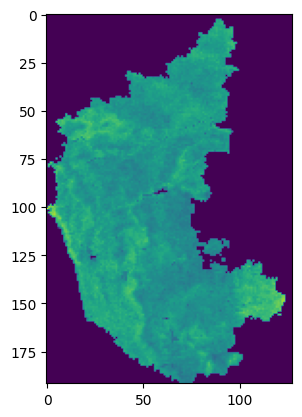

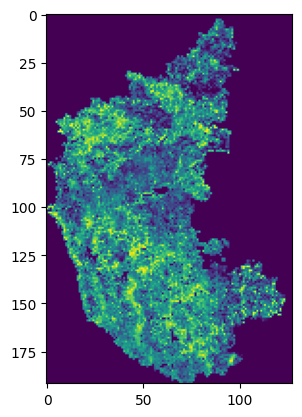

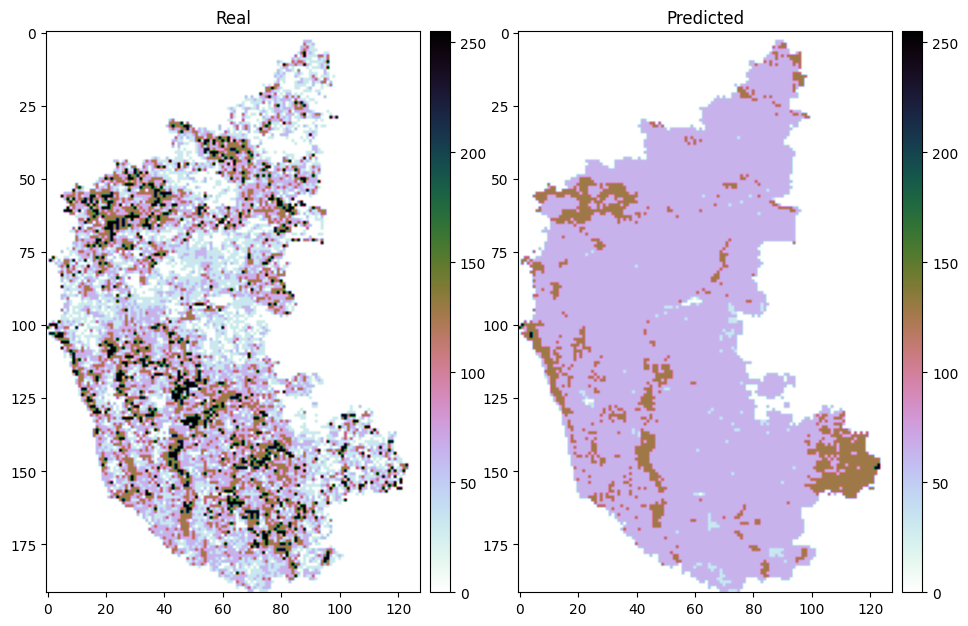

In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
# predicted_RF_06 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_ripredicted_RF_06_outputs_LR_total.npy")
pred = predicted_RF_06[0].reshape(192,128)
yreal = test_label[0].reshape(192,128)
r2 = r2_score(yreal,pred)
error = mse(yreal,pred)
huber = tf.keras.losses.Huber(delta=0.01)
print(huber(yreal,pred).numpy)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)
unscale_pred = unscale(pred,label_test[0])
unscale_real = unscale(yreal,label_test[0])
colorcoded_pred_12 = colorcoding(unscale_pred)
colorcoded_real_12 = colorcoding(unscale_real)
images = [colorcoded_real_12, colorcoded_pred_12]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="cubehelix_r")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [13]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
R2_RF_06 =[]
error_RF_06 =[]
yhat_RF_06 =[]
MSE_RF_06=[]
adj_RF_r2_06 =[]
for i in range(len(test_image)):
    pred = predicted_RF_06[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal, pred)
    adj = 1 - (1-r2)*(len(yreal)-1)/(len(yreal)-pred.shape[1]-1)
    yhat_RF_06.append(pred)
    R2_RF_06.append(r2)
    error_RF_06.append(err)
    MSE_RF_06.append(mean_err)
    adj_RF_r2_06.append(adj)
print(adj_RF_r2_06)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\6 monthly/R2_score_06monthly_RF.npy", R2_RF_06)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\6 monthly/MAE_for_06monthly_RF.npy", error_RF_06)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\6 monthly/MSE_for_06monthly_RF.npy", MSE_RF_06)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\6 monthly/predicted_06monthly_RF.npy",yhat_RF_06)

[-0.46453730742774524, -0.6972301101420835, -0.7298528120997481, -0.4028623945479757, 0.04318752852347685, 0.19733145525873763, 0.3149788328341221, 0.4006071419912478, 0.36916659530468277, 0.36350372034009537, 0.19738105850841225, 0.21555705410459003, 0.16163428644946365, 0.27353075000731875, 0.1866476495295567, 0.3520151915265559, 0.3503659529620031, 0.48223753192610264, 0.5278984072627538, 0.5598251414115614, 0.48918049961197274, 0.40019246832861843, 0.31235760985612115, 0.28814906051989064, 0.3737964917228843, 0.31178895656261696, 0.2369920644943273, 0.2489451686093065, 0.3656825980198324, 0.39904760595062405, 0.39608380455560377, 0.47715305383769746, 0.5402564295719874, 0.4714083851599409, 0.40725089579769036, 0.3409735281585705, 0.32352712370222236, 0.3429968634479683, 0.13289649892902333, 0.3326091812723939, 0.3042984967267206, 0.38983178284964126, 0.40889687547941167, 0.42267790821531037, 0.5090381317338988]


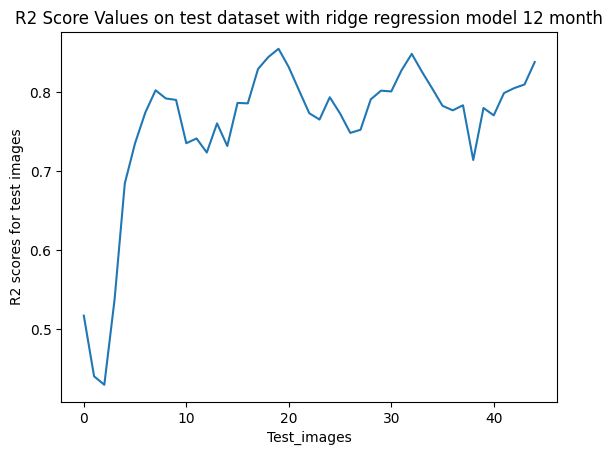

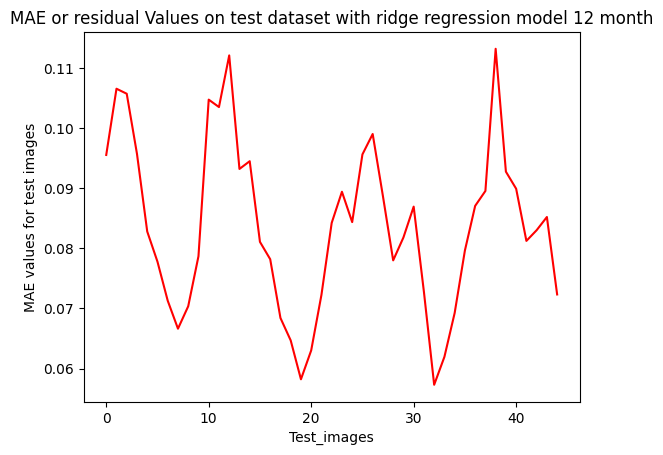

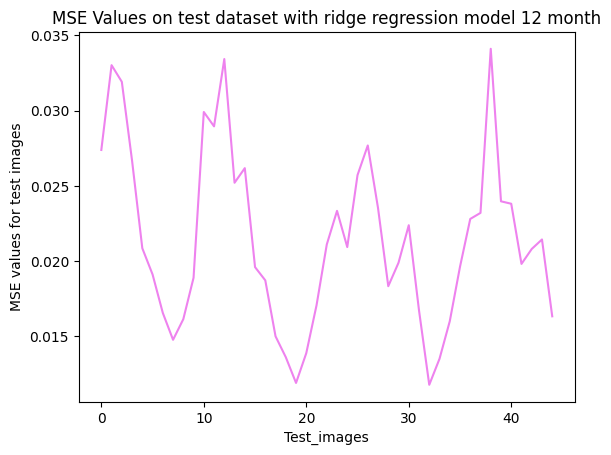

In [11]:
# R2_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/R2_ridge_score_LR_total.npy")
# error_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MAE_for_LR_total.npy")
# MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MSE_for_LR_total.npy")
# print(error_ridge)
plt.plot(R2_RF_06)
plt.xlabel("Test_images")
plt.ylabel("R2 scores for test images")
plt.title("R2 Score Values on test dataset with ridge regression model 12 month")
plt.show()
plt.plot(error_RF_06,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ridge regression model 12 month")
plt.show()
plt.plot(MSE_RF_06, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ridge regression model 12 month")
#plt.legend(["MAE","MSE"])
plt.show()

In [12]:
np.mean(R2_RF_06), np.max(R2_RF_06), np.mean(MSE_RF_06), np.mean(error_RF_06)

(0.757583162406138, 0.854811434078159, 0.02146195407566154, 0.0837488061642099)

## 1 monthly

In [14]:
# load datasets
data_01 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\1monthly_scaled100_avhrr_vhi_1981_2022.npy")
label_01 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/1monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
data_01_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/1monthly_scaledto1_avhrr_vhi_1981_2022.npy")
label_01_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\1monthly_scaledto1_avhrr_vhi_1981_2022_label.npy")
print(data_01.shape, label_01.shape, data_01_norm.shape, label_01_norm.shape)
## Splitting into train and test
np.max(data_01), np.min(data_01), np.max(data_01_norm), np.min(data_01_norm)


(530, 192, 128, 1) (530, 192, 128, 1) (530, 192, 128, 1) (530, 192, 128, 1)


(100.00000000000001, 0.0, 1.0, 0.0)

In [15]:
train_image = data_01_norm[:485]
train_label = label_01_norm[:485]
test_image = data_01_norm[485:]
test_label = label_01_norm[485:]
print(train_image.shape, train_label.shape, test_image.shape, test_label.shape)
data_train = data_01[:485]
label_train = label_01[:485]
data_test = data_01[485:]
label_test= label_01[485:]
print(data_train.shape, label_train.shape, data_test.shape, label_test.shape)
train_image_flattened = train_image.reshape(485,24576)
train_label_flattened = train_label.reshape(485,24576)
test_image_flattened = test_image.reshape(45,24576)
test_label_flattened = test_label.reshape(45,24576)

(485, 192, 128, 1) (485, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)
(485, 192, 128, 1) (485, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)


In [16]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=3,max_depth=2, verbose=2, n_jobs=-1)

# train model
forest.fit(train_image_flattened, train_label_flattened)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 3building tree 2 of 3
building tree 3 of 3



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.5min finished


RandomForestRegressor(max_depth=2, n_estimators=3, n_jobs=-1, verbose=2)

In [17]:
predicted_RF_01 = forest.predict(test_image_flattened)
predicted_RF_01 = predicted_RF_01.reshape(45,192,128)
print(predicted_RF_01.shape)

(45, 192, 128)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.0008709088>>
0.02432911258394193 0.566775612615007


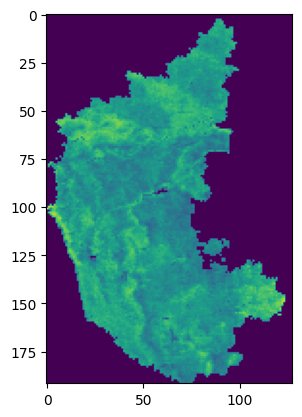

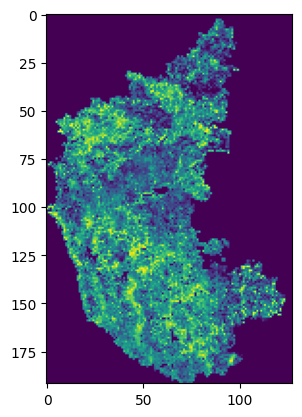

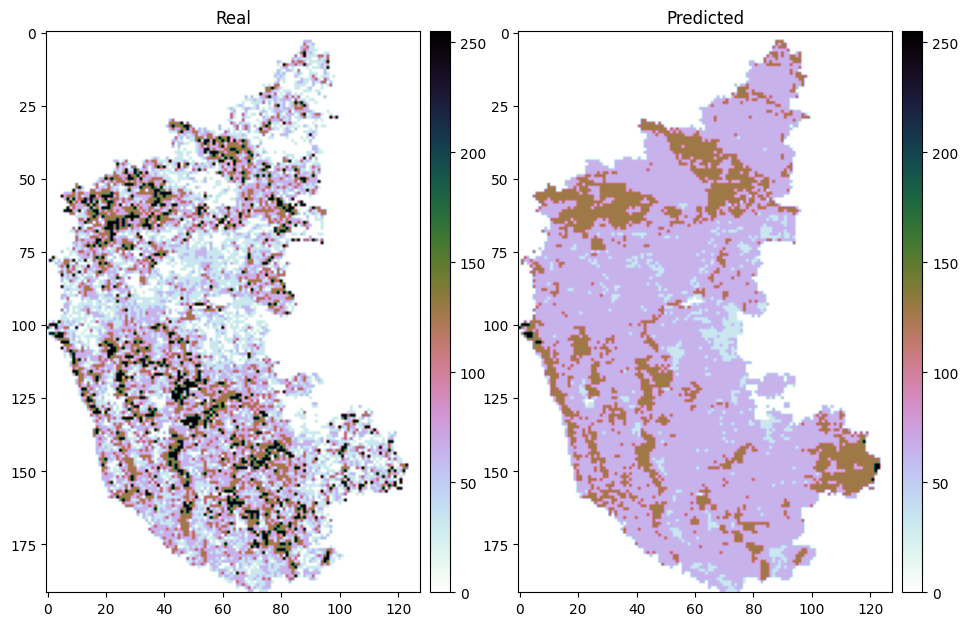

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
# predicted_RF_01 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_ripredicted_RF_01_outputs_LR_total.npy")
pred = predicted_RF_01[0].reshape(192,128)
yreal = test_label[0].reshape(192,128)
r2 = r2_score(yreal,pred)
error = mse(yreal,pred)
huber = tf.keras.losses.Huber(delta=0.01)
print(huber(yreal,pred).numpy)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)
unscale_pred = unscale(pred,label_test[0])
unscale_real = unscale(yreal,label_test[0])
colorcoded_pred_01 = colorcoding(unscale_pred)
colorcoded_real_01 = colorcoding(unscale_real)
images = [colorcoded_real_01, colorcoded_pred_01]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="cubehelix_r")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
R2_RF_01 =[]
error_RF_01 =[]
yhat_RF_01 =[]
MSE_RF_01=[]
adj_RF_r2_01 =[]
for i in range(len(test_image)):
    pred = predicted_RF_01[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal, pred)
    adj = 1 - (1-r2)*(len(yreal)-1)/(len(yreal)-pred.shape[1]-1)
    yhat_RF_01.append(pred)
    R2_RF_01.append(r2)
    error_RF_01.append(err)
    MSE_RF_01.append(mean_err)
    adj_RF_r2_01.append(adj)
print(adj_RF_r2_01)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\1 monthly/R2_score_01monthly_RF.npy", R2_RF_01)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\1 monthly/MAE_for_01monthly_RF.npy", error_RF_01)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\1 monthly/MSE_for_01monthly_RF.npy", MSE_RF_01)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\1 monthly/predicted_01monthly_RF.npy",yhat_RF_01)

[-0.3134263173100582, -0.6070044353060688, -0.606514972988696, -0.3425842089788962, 0.09910028388687375, 0.2804587981073562, 0.3341409451972166, 0.3748777457382084, 0.39887843836675263, 0.35849035238939253, 0.23770882662292392, 0.42743550734091573, 0.3346283162829192, 0.40228797855656084, 0.29349801326109815, 0.37702236500298114, 0.4323968766783953, 0.46187226580210405, 0.5235657001204275, 0.5662021866967015, 0.5729518538172831, 0.5068586133803801, 0.39809445643770924, 0.4307216041416573, 0.44978124964608945, 0.4093599005834091, 0.43799622299793195, 0.34056212546596265, 0.3834420287443101, 0.42966674663275806, 0.4583772575023991, 0.5093309421284167, 0.5493991650473424, 0.5421593066295252, 0.4930503106251224, 0.4088224127829093, 0.468007957301538, 0.46603424767911994, 0.3501426790536085, 0.4633740840201749, 0.33845377039119995, 0.4078175074197422, 0.46733168258657054, 0.47075950589656923, 0.5319206024432825]


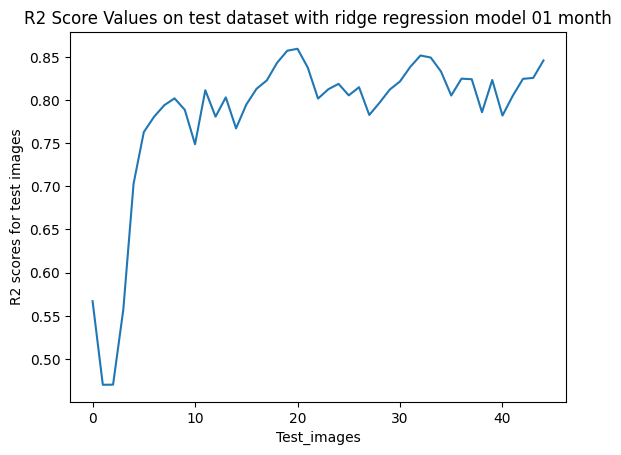

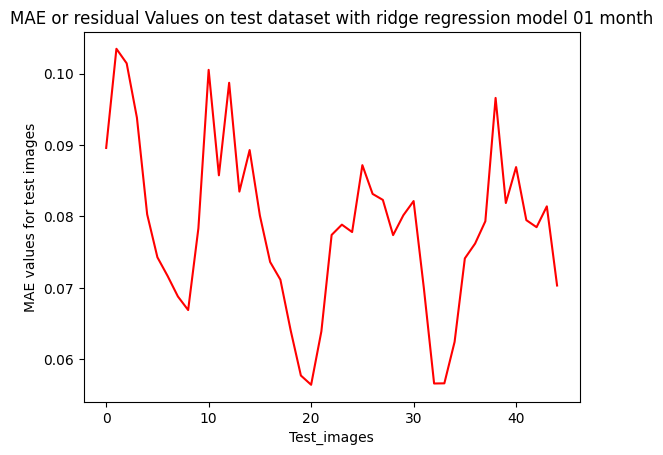

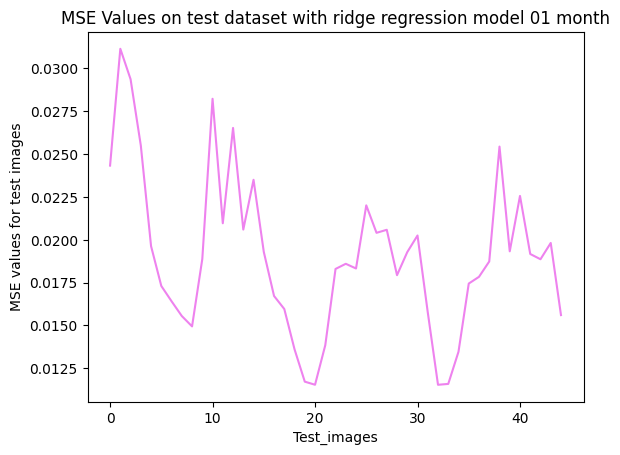

In [30]:
# R2_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/R2_ridge_score_LR_total.npy")
# error_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MAE_for_LR_total.npy")
# MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MSE_for_LR_total.npy")
# print(error_ridge)
plt.plot(R2_RF_01)
plt.xlabel("Test_images")
plt.ylabel("R2 scores for test images")
plt.title("R2 Score Values on test dataset with ridge regression model 01 month")
plt.show()
plt.plot(error_RF_01,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ridge regression model 01 month")
plt.show()
plt.plot(MSE_RF_01, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ridge regression model 01 month")
#plt.legend(["MAE","MSE"])
plt.show()

In [21]:
np.mean(R2_RF_01), np.max(R2_RF_01), np.mean(MSE_RF_01), np.mean(error_RF_01)

(0.7824315772688533,
 0.8591411873847583,
 0.019075404570286607,
 0.07844323488695396)

## 3 monthly

In [22]:
# load datasets
data_03 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\3monthly_scaled100_avhrr_vhi_1981_2022.npy")
label_03 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/3monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
data_03_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/3monthly_scaledto1_avhrr_vhi_1981_2022.npy")
label_03_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\3monthly_scaledto1_avhrr_vhi_1981_2022_label.npy")
print(data_03.shape, label_03.shape, data_03_norm.shape, label_03_norm.shape)
## Splitting into train and test
np.max(data_03), np.min(data_03), np.max(data_03_norm), np.min(data_03_norm)


(528, 192, 128, 1) (528, 192, 128, 1) (528, 192, 128, 1) (528, 192, 128, 1)


(100.00000000000001, 0.0, 1.0, 0.0)

In [23]:
train_image = data_03_norm[:483]
train_label = label_03_norm[:483]
test_image = data_03_norm[483:]
test_label = label_03_norm[483:]
print(train_image.shape, train_label.shape, test_image.shape, test_label.shape)
data_train = data_03[:483]
label_train = label_03[:483]
data_test = data_03[483:]
label_test= label_03[483:]
print(data_train.shape, label_train.shape, data_test.shape, label_test.shape)
train_image_flattened = train_image.reshape(483,24576)
train_label_flattened = train_label.reshape(483,24576)
test_image_flattened = test_image.reshape(45,24576)
test_label_flattened = test_label.reshape(45,24576)

(483, 192, 128, 1) (483, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)
(483, 192, 128, 1) (483, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)


In [24]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=3,max_depth=2, verbose=2, n_jobs=-1)

# train model
forest.fit(train_image_flattened, train_label_flattened)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.7min finished


RandomForestRegressor(max_depth=2, n_estimators=3, n_jobs=-1, verbose=2)

In [25]:
predicted_RF_03 = forest.predict(test_image_flattened)
predicted_RF_03 = predicted_RF_03.reshape(45,192,128)
print(predicted_RF_03.shape)

(45, 192, 128)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.0009483199>>
0.02879546956602818 0.48319004657709386


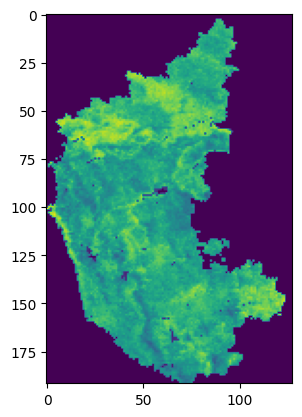

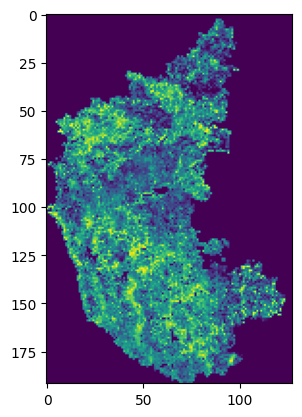

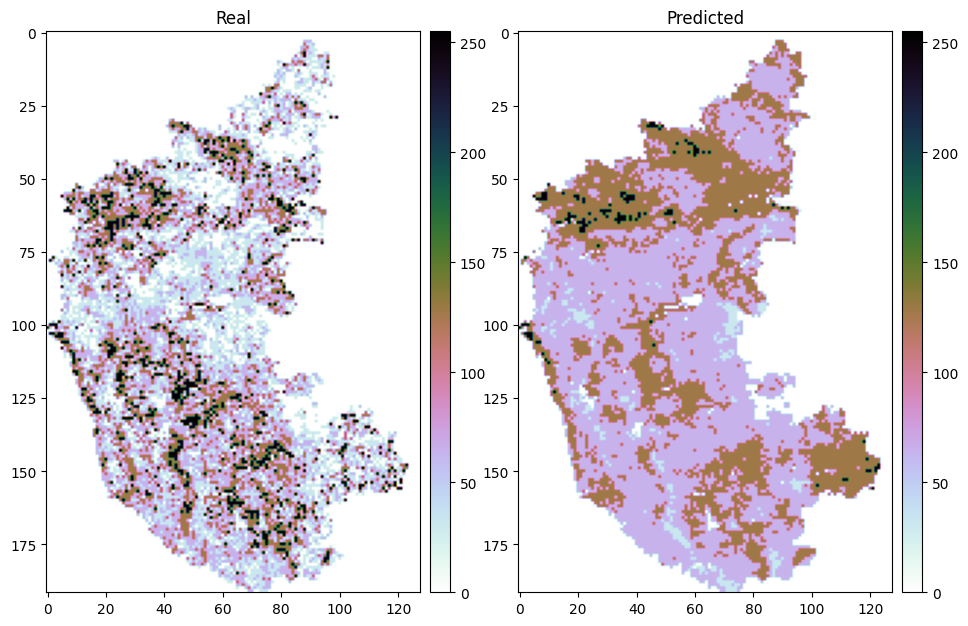

In [26]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
# predicted_RF_03 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_ripredicted_RF_03_outputs_LR_total.npy")
pred = predicted_RF_03[0].reshape(192,128)
yreal = test_label[0].reshape(192,128)
r2 = r2_score(yreal,pred)
error = mse(yreal,pred)
huber = tf.keras.losses.Huber(delta=0.01)
print(huber(yreal,pred).numpy)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)
unscale_pred = unscale(pred,label_test[0])
unscale_real = unscale(yreal,label_test[0])
colorcoded_pred_03 = colorcoding(unscale_pred)
colorcoded_real_03 = colorcoding(unscale_real)
images = [colorcoded_real_03, colorcoded_pred_03]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="cubehelix_r")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
R2_RF_03 =[]
error_RF_03 =[]
yhat_RF_03 =[]
MSE_RF_03=[]
adj_RF_r2_03 =[]
for i in range(len(test_image)):
    pred = predicted_RF_03[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal, pred)
    adj = 1 - (1-r2)*(len(yreal)-1)/(len(yreal)-pred.shape[1]-1)
    yhat_RF_03.append(pred)
    R2_RF_03.append(r2)
    error_RF_03.append(err)
    MSE_RF_03.append(mean_err)
    adj_RF_r2_03.append(adj)
print(adj_RF_r2_03)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\3 monthly/R2_score_03monthly_RF.npy", R2_RF_03)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\3 monthly/MAE_for_03monthly_RF.npy", error_RF_03)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\3 monthly/MSE_for_03monthly_RF.npy", MSE_RF_03)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\3 monthly/predicted_03monthly_RF.npy",yhat_RF_03)

[-0.5668365254567473, -0.7640993930501396, -0.7801792782304382, -0.46880614296176715, 0.025635244689832803, 0.2647375813824998, 0.3329144211533156, 0.3942632453685043, 0.4620802634443537, 0.2203324537400091, 0.31188368912028974, 0.04613956361327509, 0.18724021592121998, 0.3612532808722929, 0.3570142015878668, 0.417228076838419, 0.47339437942578866, 0.5423927461134794, 0.48662192373555346, 0.448937660116316, 0.46720705686988184, 0.48891102844252776, 0.4118339085162448, 0.40854035007954714, 0.4046146963173768, 0.2958367536961548, 0.35402106909006237, 0.4187344296274016, 0.43072023149517813, 0.4803628680250952, 0.4112271224286339, 0.43607718327760137, 0.4667972669877132, 0.4552956002388373, 0.49796887060174244, 0.4512328854658646, 0.4121081283384611, 0.11845110758380828, 0.1889943393609852, 0.3126708210732013, 0.37140571188315585, 0.42475000229424886, 0.4077723955032585, 0.3601308922806379, 0.38285191473941993]


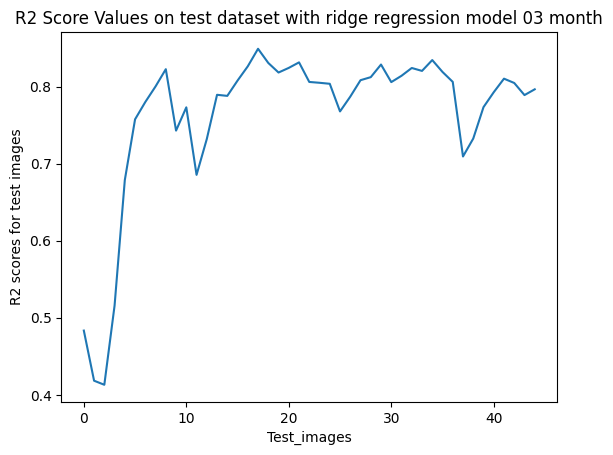

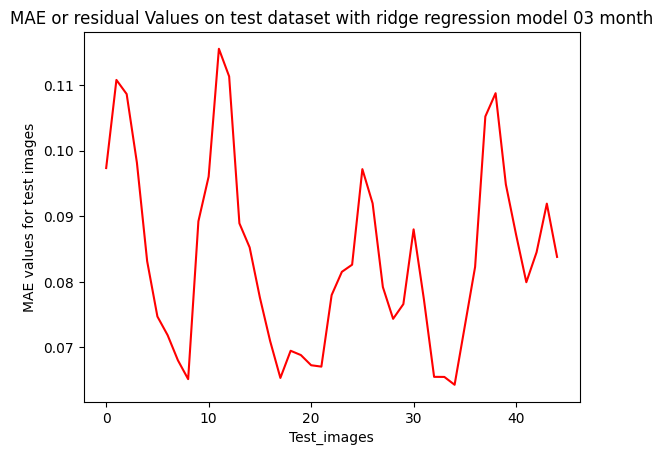

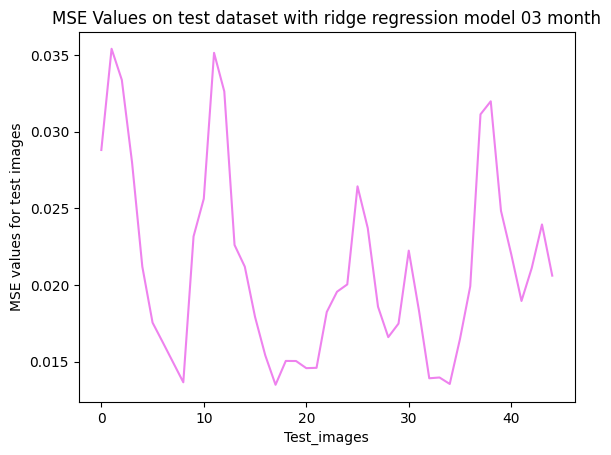

In [28]:
# R2_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/R2_ridge_score_LR_total.npy")
# error_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MAE_for_LR_total.npy")
# MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MSE_for_LR_total.npy")
# print(error_ridge)
plt.plot(R2_RF_03)
plt.xlabel("Test_images")
plt.ylabel("R2 scores for test images")
plt.title("R2 Score Values on test dataset with ridge regression model 03 month")
plt.show()
plt.plot(error_RF_03,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ridge regression model 03 month")
plt.show()
plt.plot(MSE_RF_03, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ridge regression model 03 month")
#plt.legend(["MAE","MSE"])
plt.show()

In [29]:
np.mean(R2_RF_03), np.max(R2_RF_03), np.mean(MSE_RF_03), np.mean(error_RF_03)

(0.7625912562214521,
 0.8490614817023519,
 0.021087518164808434,
 0.08364630892585878)

## 9 monthly

In [48]:
# load datasets
data_09 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\9monthly_scaled100_avhrr_vhi_1981_2022.npy")
label_09 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/9monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
data_09_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/9monthly_scaledto1_avhrr_vhi_1981_2022.npy")
label_09_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\9monthly_scaledto1_avhrr_vhi_1981_2022_label.npy")
print(data_09.shape, label_09.shape, data_09_norm.shape, label_09_norm.shape)
## Splitting into train and test
np.max(data_09), np.min(data_09), np.max(data_09_norm), np.min(data_09_norm)


(522, 192, 128, 1) (522, 192, 128, 1) (522, 192, 128, 1) (522, 192, 128, 1)


(100.00000000000001, 0.0, 1.0, 0.0)

In [49]:
train_image = data_09_norm[:477]
train_label = label_09_norm[:477]
test_image = data_09_norm[477:]
test_label = label_09_norm[477:]
print(train_image.shape, train_label.shape, test_image.shape, test_label.shape)
data_train = data_09[:477]
label_train = label_09[:477]
data_test = data_09[477:]
label_test= label_09[477:]
print(data_train.shape, label_train.shape, data_test.shape, label_test.shape)
train_image_flattened = train_image.reshape(477,24576)
train_label_flattened = train_label.reshape(477,24576)
test_image_flattened = test_image.reshape(45,24576)
test_label_flattened = test_label.reshape(45,24576)

(477, 192, 128, 1) (477, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)
(477, 192, 128, 1) (477, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)


In [50]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=3,max_depth=2, verbose=2, n_jobs=-1)

# train model
forest.fit(train_image_flattened, train_label_flattened)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 3building tree 2 of 3

building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.4min finished


RandomForestRegressor(max_depth=2, n_estimators=3, n_jobs=-1, verbose=2)

In [51]:
predicted_RF_09 = forest.predict(test_image_flattened)
predicted_RF_09 = predicted_RF_09.reshape(45,192,128)
print(predicted_RF_09.shape)

(45, 192, 128)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.0010638592>>
0.035579986631940466 0.3596135734823467


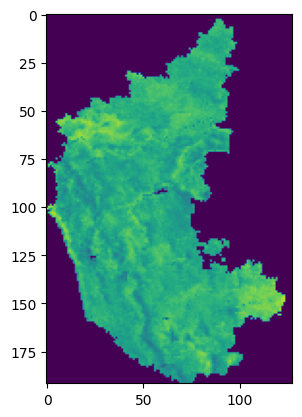

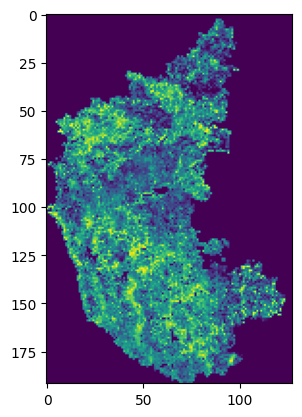

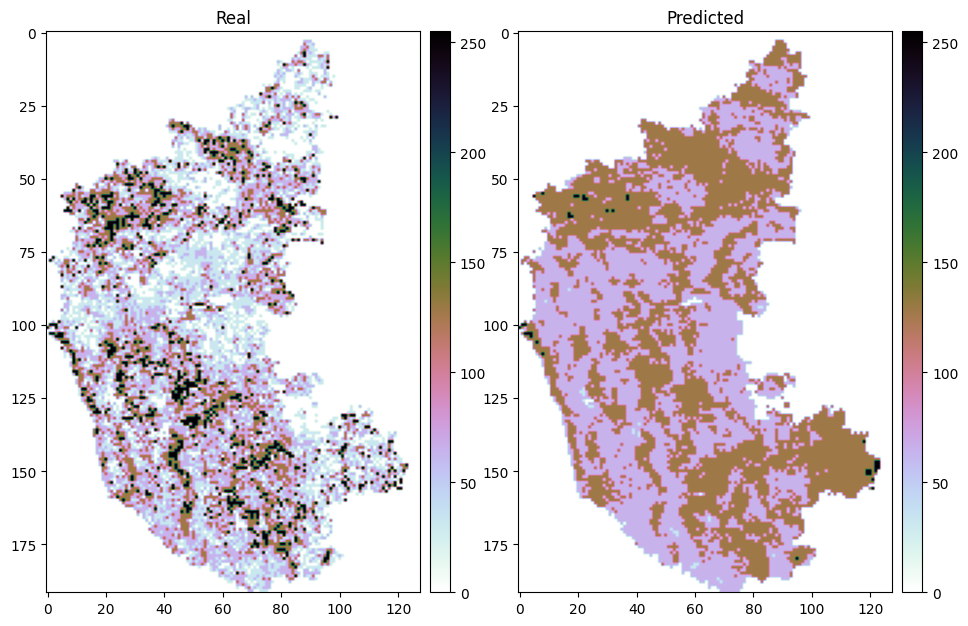

In [52]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
# predicted_RF_06 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_ripredicted_RF_06_outputs_LR_total.npy")
pred = predicted_RF_09[0].reshape(192,128)
yreal = test_label[0].reshape(192,128)
r2 = r2_score(yreal,pred)
error = mse(yreal,pred)
huber = tf.keras.losses.Huber(delta=0.01)
print(huber(yreal,pred).numpy)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)
unscale_pred = unscale(pred,label_test[0])
unscale_real = unscale(yreal,label_test[0])
colorcoded_pred_09 = colorcoding(unscale_pred)
colorcoded_real_09 = colorcoding(unscale_real)
images = [colorcoded_real_09, colorcoded_pred_09]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="cubehelix_r")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [53]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
R2_RF_09 =[]
error_RF_09 =[]
yhat_RF_09 =[]
MSE_RF_09=[]
adj_RF_r2_09 =[]
for i in range(len(test_image)):
    pred = predicted_RF_09[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal, pred)
    adj = 1 - (1-r2)*(len(yreal)-1)/(len(yreal)-pred.shape[1]-1)
    yhat_RF_09.append(pred)
    R2_RF_09.append(r2)
    error_RF_09.append(err)
    MSE_RF_09.append(mean_err)
    adj_RF_r2_09.append(adj)
print(adj_RF_r2_09)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\9 monthly/R2_score_09monthly_RF.npy", R2_RF_09)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\9 monthly/MAE_for_09monthly_RF.npy", error_RF_09)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\9 monthly/MSE_for_09monthly_RF.npy", MSE_RF_09)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\9 monthly/predicted_09monthly_RF.npy",yhat_RF_09)

[-0.9414890073789173, -0.8392413278170163, -0.8644233210294376, -0.7107306374111944, -0.26213373723076927, 0.13815586150577364, 0.29700714431795716, 0.36408774544878764, 0.39355045723164406, 0.3793290852926672, 0.057796986293521924, 0.2633991342107044, 0.1465632778466257, 0.1706421486906725, 0.21734068197906586, 0.3448805691365149, 0.31060596131978846, 0.42750267504934625, 0.5448784328921206, 0.5680184213418977, 0.5776164988265178, 0.5274227145237369, 0.4047193369188986, 0.39238241109771854, 0.4108795898086758, 0.3501661359054111, 0.39212988584570163, 0.3650333894440916, 0.3612079578680517, 0.3351004524099622, 0.35277572078571395, 0.5103198611446227, 0.549905524888757, 0.5436072511021841, 0.5145083527194485, 0.36072336513165004, 0.33718335615679385, 0.41329225112588686, 0.33937942131098675, 0.4580871141624526, 0.35143579944573944, 0.3815554042193917, 0.42633461032558406, 0.3717562818563389, 0.5432394948708746]


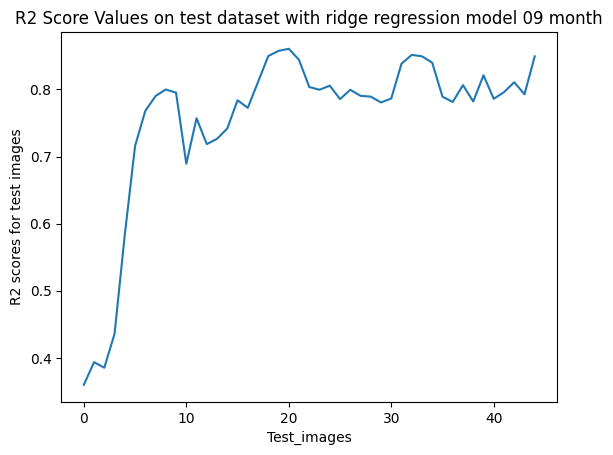

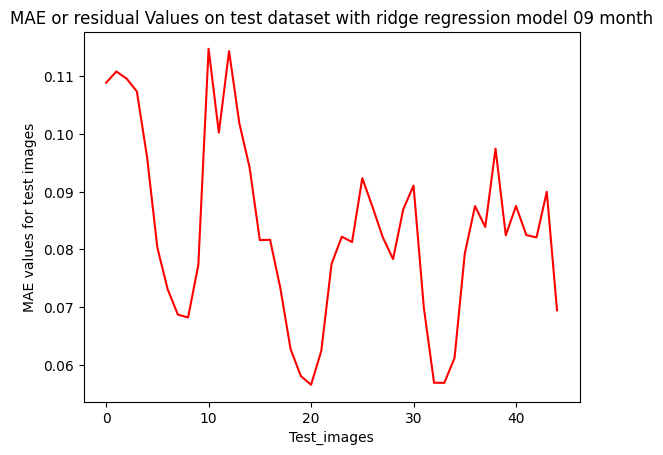

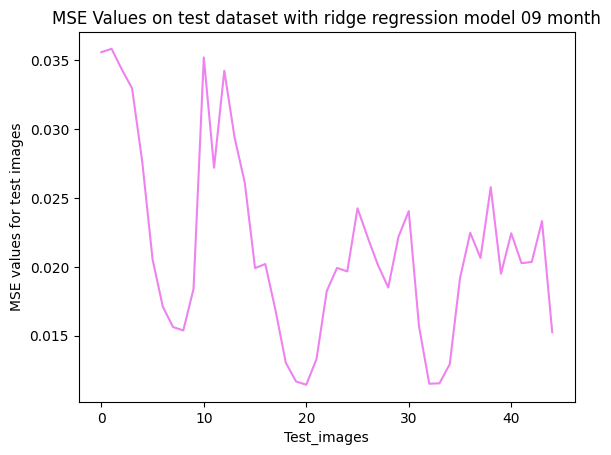

In [54]:
# R2_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/R2_ridge_score_LR_total.npy")
# error_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MAE_for_LR_total.npy")
# MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MSE_for_LR_total.npy")
# print(error_ridge)
plt.plot(R2_RF_09)
plt.xlabel("Test_images")
plt.ylabel("R2 scores for test images")
plt.title("R2 Score Values on test dataset with ridge regression model 09 month")
plt.show()
plt.plot(error_RF_09,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ridge regression model 09 month")
plt.show()
plt.plot(MSE_RF_09, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ridge regression model 09 month")
#plt.legend(["MAE","MSE"])
plt.show()

In [55]:
np.mean(R2_RF_09), np.max(R2_RF_09), np.mean(MSE_RF_09), np.mean(error_RF_09)

(0.7550110148011462,
 0.8606797875710503,
 0.021365873599189476,
 0.08328998740298875)

## 12 monthly

In [12]:
# load datasets
data_12 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\12monthly_scaled100_avhrr_vhi_1981_2022.npy")
label_12 = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
data_12_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_scaledto1_avhrr_vhi_1981_2022.npy")
label_12_norm = np.load(r"E:\Jyoti Shukla - MS\monthly avhrr total data\12monthly_scaledto1_avhrr_vhi_1981_2022_label.npy")
print(data_12.shape, label_12.shape, data_12_norm.shape, label_12_norm.shape)
## Splitting into train and test
np.max(data_12), np.min(data_12), np.max(data_12_norm), np.min(data_12_norm)


(519, 192, 128, 1) (519, 192, 128, 1) (519, 192, 128, 1) (519, 192, 128, 1)


(100.00000000000001, 0.0, 1.0, 0.0)

In [13]:
train_image = data_12_norm[:474]
train_label = label_12_norm[:474]
test_image = data_12_norm[474:]
test_label = label_12_norm[474:]
print(train_image.shape, train_label.shape, test_image.shape, test_label.shape)
data_train = data_12[:474]
label_train = label_12[:474]
data_test = data_12[474:]
label_test= label_12[474:]
print(data_train.shape, label_train.shape, data_test.shape, label_test.shape)
train_image_flattened = train_image.reshape(474,24576)
train_label_flattened = train_label.reshape(474,24576)
test_image_flattened = test_image.reshape(45,24576)
test_label_flattened = test_label.reshape(45,24576)

(474, 192, 128, 1) (474, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)
(474, 192, 128, 1) (474, 192, 128, 1) (45, 192, 128, 1) (45, 192, 128, 1)


In [58]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=3,max_depth=2, verbose=2, n_jobs=-1)

# train model
forest.fit(train_image_flattened, train_label_flattened)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.5min finished


RandomForestRegressor(max_depth=2, n_estimators=3, n_jobs=-1, verbose=2)

In [59]:
predicted_RF_12 = forest.predict(test_image_flattened)
predicted_RF_12 = predicted_RF_12.reshape(45,192,128)
print(predicted_RF_12.shape)

(45, 192, 128)


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.00094291166>>
0.028046659515664294 0.4915662041378951


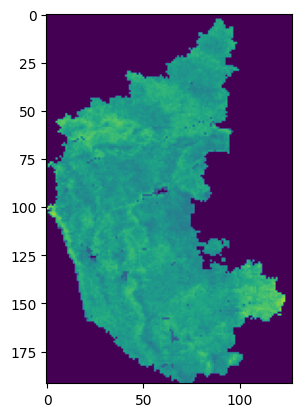

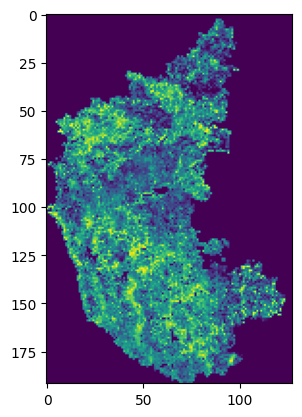

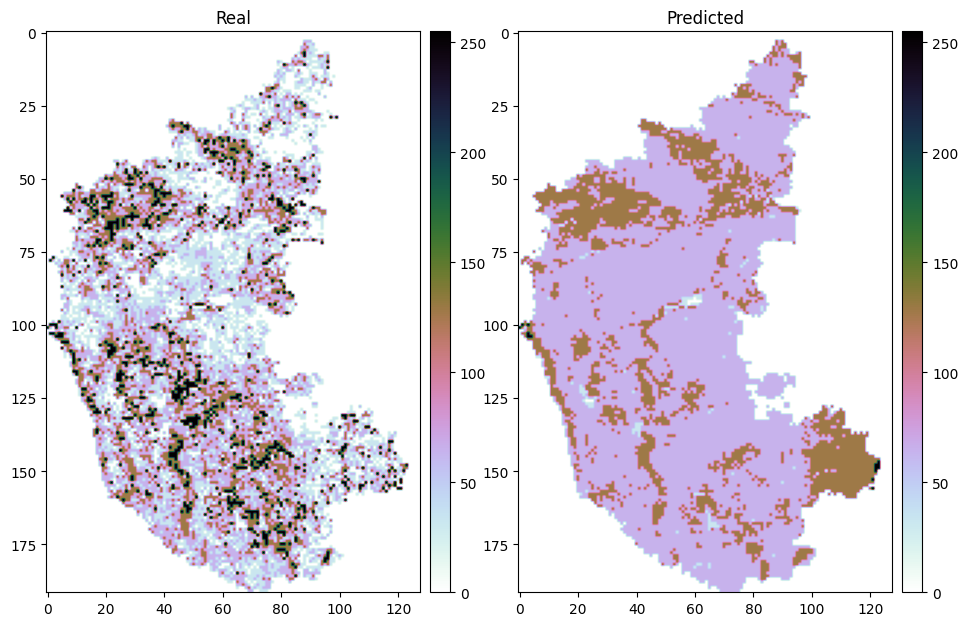

In [60]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
# predicted_RF_12 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_ripredicted_RF_12_outputs_LR_total.npy")
pred = predicted_RF_12[0].reshape(192,128)
yreal = test_label[0].reshape(192,128)
r2 = r2_score(yreal,pred)
error = mse(yreal,pred)
huber = tf.keras.losses.Huber(delta=0.01)
print(huber(yreal,pred).numpy)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)
unscale_pred = unscale(pred,label_test[0])
unscale_real = unscale(yreal,label_test[0])
colorcoded_pred_12 = colorcoding(unscale_pred)
colorcoded_real_12 = colorcoding(unscale_real)
images = [colorcoded_real_12, colorcoded_pred_12]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="cubehelix_r")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [61]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
R2_RF_12 =[]
error_RF_12 =[]
yhat_RF_12 =[]
MSE_RF_12=[]
adj_RF_r2_12 =[]
for i in range(len(test_image)):
    pred = predicted_RF_12[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal, pred)
    adj = 1 - (1-r2)*(len(yreal)-1)/(len(yreal)-pred.shape[1]-1)
    yhat_RF_12.append(pred)
    R2_RF_12.append(r2)
    error_RF_12.append(err)
    MSE_RF_12.append(mean_err)
    adj_RF_r2_12.append(adj)
print(adj_RF_r2_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/R2_score_12monthly_RF.npy", R2_RF_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/MAE_for_12monthly_RF.npy", error_RF_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/MSE_for_12monthly_RF.npy", MSE_RF_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/predicted_12monthly_RF.npy",yhat_RF_12)

[-0.5414421430105085, -0.7571128436536447, -0.7724305494406252, -0.483849959317999, 0.014479643455136082, 0.05983001974659252, 0.2703186878822065, 0.4544306322785261, 0.4325798016730654, 0.3590938382374709, 0.30352832919973316, 0.30981257001236706, 0.05270190696560684, 0.1030918036915951, 0.26368675533736097, 0.3536516880411442, 0.3970102668709202, 0.48444308361031396, 0.3590123265213008, 0.49385647660292586, 0.5418760368997164, 0.4791125700447888, 0.43338608547305524, 0.41428749365562956, 0.4169794949630925, 0.16738490657306082, 0.3616853170249378, 0.42190556573820426, 0.4282679041691707, 0.470486359845656, 0.39960468423650053, 0.38163313789344133, 0.5207847828918946, 0.5251777663986597, 0.48579199540181695, 0.46499391782378885, 0.39971846653126164, 0.3577801480000665, 0.06912483163229155, 0.1549367673188181, 0.29277493895136597, 0.431154630808952, 0.41283831446336827, 0.36035613650668763, 0.3862493074660095]


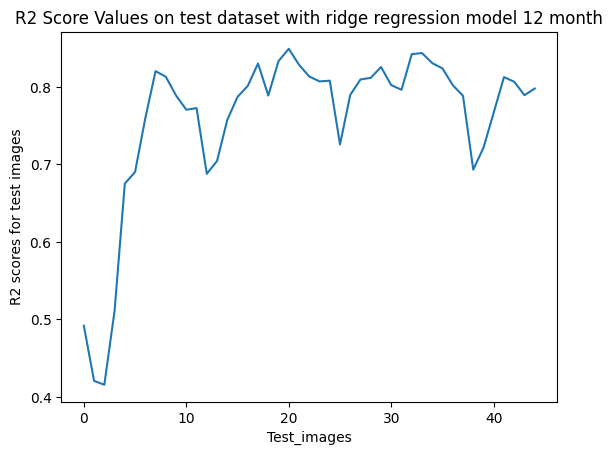

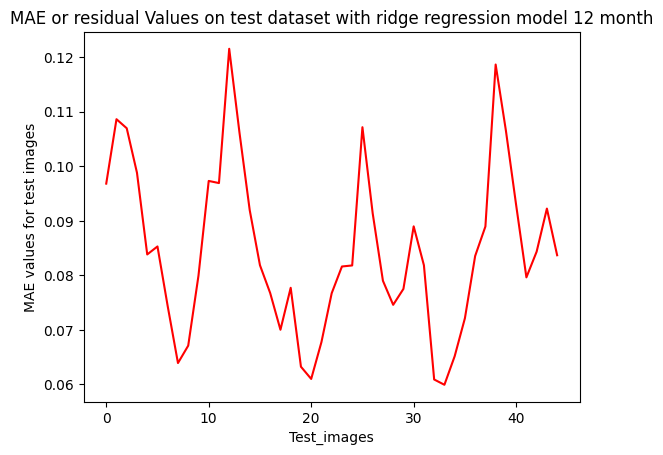

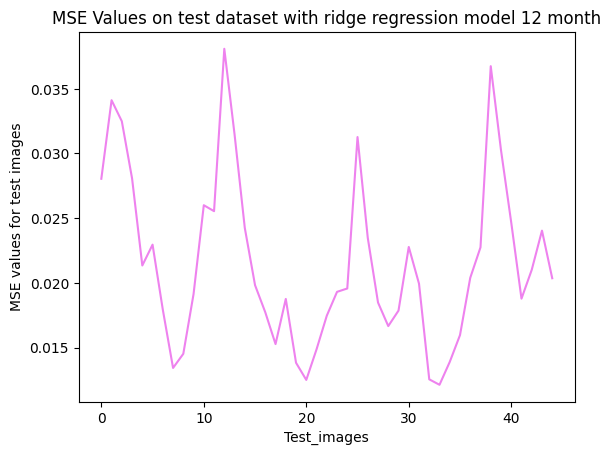

In [62]:
# R2_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/R2_ridge_score_LR_total.npy")
# error_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MAE_for_LR_total.npy")
# MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MSE_for_LR_total.npy")
# print(error_ridge)
plt.plot(R2_RF_12)
plt.xlabel("Test_images")
plt.ylabel("R2 scores for test images")
plt.title("R2 Score Values on test dataset with ridge regression model 12 month")
plt.show()
plt.plot(error_RF_12,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ridge regression model 12 month")
plt.show()
plt.plot(MSE_RF_12, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ridge regression model 12 month")
#plt.legend(["MAE","MSE"])
plt.show()

In [63]:
np.mean(R2_RF_12), np.max(R2_RF_12), np.mean(MSE_RF_12), np.mean(error_RF_12)

(0.757638625411424,
 0.8488910488203253,
 0.021567649333580238,
 0.08457905284517159)

XGB

In [14]:
import xgboost as xg
# Instantiation
xgbr = xg.XGBRegressor(max_depth = 4, booster ='gbtree',objective='reg:squarederror',
                  n_estimators = 2, n_jobs= -1, random_state = 0, verbosity =1)
xgbr.fit(train_image_flattened, train_label_flattened)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=0, ...)

In [15]:
predicted_xgb_12 = xgbr.predict(test_image_flattened)
predicted_xgb_12 = predicted_xgb_12.reshape(45,192,128)
print(predicted_xgb_12.shape)

(45, 192, 128)


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.0020380644>>
0.05257978428839875 -0.3466549811447763


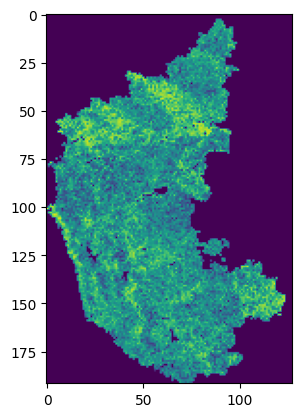

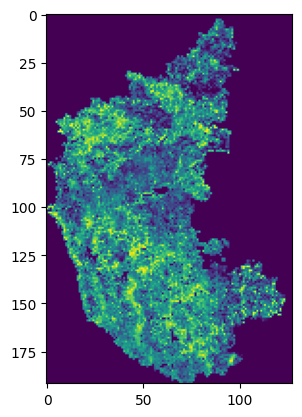

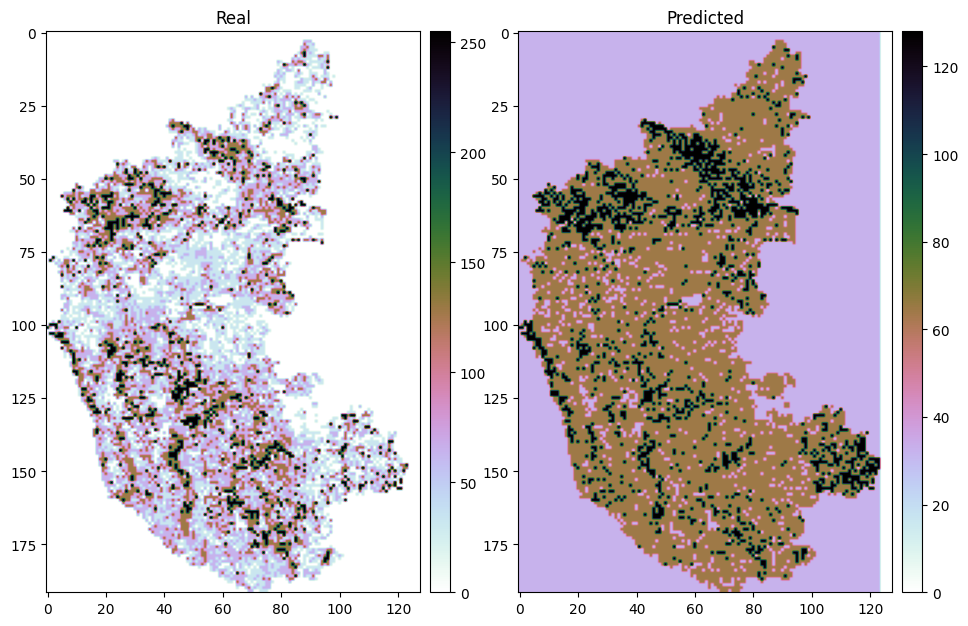

In [16]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
# predicted_xgb_12 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_ripredicted_xgb_12_outputs_LR_total.npy")
pred = predicted_xgb_12[0].reshape(192,128)
yreal = test_label[0].reshape(192,128)
r2 = r2_score(yreal,pred)
error = mse(yreal,pred)
huber = tf.keras.losses.Huber(delta=0.01)
print(huber(yreal,pred).numpy)
print(error,r2)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)
unscale_pred = unscale(pred,label_test[0])
unscale_real = unscale(yreal,label_test[0])
colorcoded_pred_12 = colorcoding(unscale_pred)
colorcoded_real_12 = colorcoding(unscale_real)
images = [colorcoded_real_12, colorcoded_pred_12]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(pad=4.0)
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="cubehelix_r")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
R2_xgb_12 =[]
error_xgb_12 =[]
yhat_xgb_12 =[]
MSE_xgb_12=[]
adj_xgb_r2_12 =[]
for i in range(len(test_image)):
    pred = predicted_xgb_12[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    r2 = r2_score(yreal,pred)
    err = mae(yreal,pred)
    mean_err = mse(yreal, pred)
    adj = 1 - (1-r2)*(len(yreal)-1)/(len(yreal)-pred.shape[1]-1)
    yhat_xgb_12.append(pred)
    R2_xgb_12.append(r2)
    error_xgb_12.append(err)
    MSE_xgb_12.append(mean_err)
    adj_xgb_r2_12.append(adj)
print(adj_xgb_r2_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/R2_score_12monthly_xgb.npy", R2_xgb_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/MAE_for_12monthly_xgb.npy", error_xgb_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/MSE_for_12monthly_xgb.npy", MSE_xgb_12)
np.save(r"E:\Jyoti Shukla - MS\codes\AVHRR codes\Monthly outputs\12 monthly/predicted_12monthly_xgb.npy",yhat_xgb_12)

[-3.082715895216703, -3.1308103042611997, -3.1871045087553203, -2.846177028698485, -2.181775928344565, -1.7974388738786935, -1.5431798190036714, -1.4944926996363805, -1.5267995215300676, -1.5132569634502402, -1.6042565969577134, -1.5649302928080586, -1.7804479808930758, -1.804128489522053, -1.8804632137552448, -1.792472562055909, -1.7522850964695134, -1.5605250955363892, -1.4013434138243066, -1.266218746308879, -1.318672009154414, -1.3653669196140101, -1.5270380686609926, -1.5558052365481339, -1.5931582205165458, -1.6059094448123168, -1.5646846004446004, -1.6060969656374287, -1.5695601205061003, -1.5346534354286927, -1.5041362335151578, -1.3914644452684413, -1.3534799681983332, -1.3180168467317297, -1.3902718368746725, -1.4630924976516164, -1.5159387871243757, -1.64667007966522, -1.7252452106042209, -1.5998633727871163, -1.589575315091889, -1.505781272349839, -1.5007301789143797, -1.4041175646684954, -1.2739082304223373]


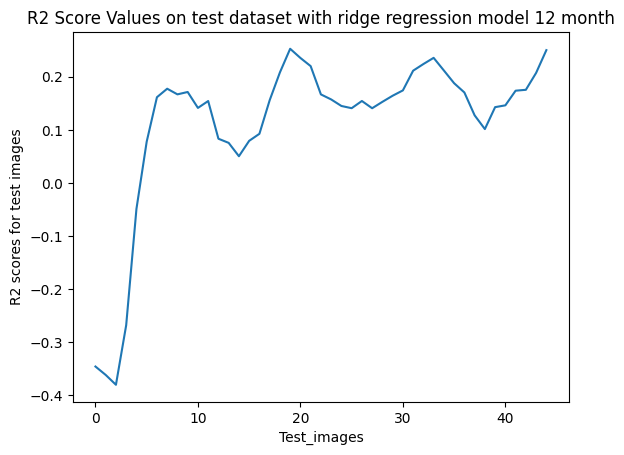

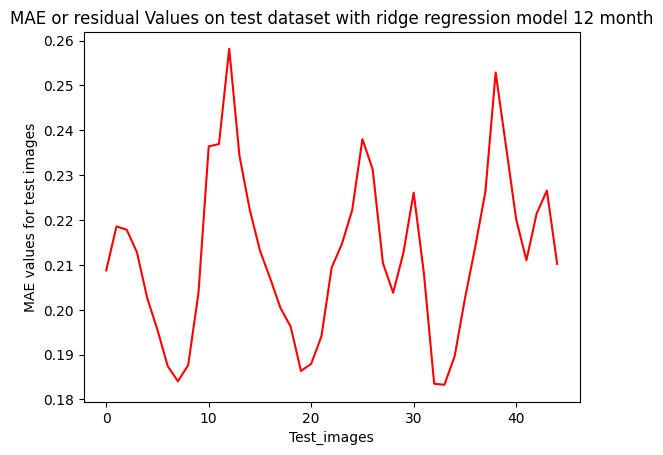

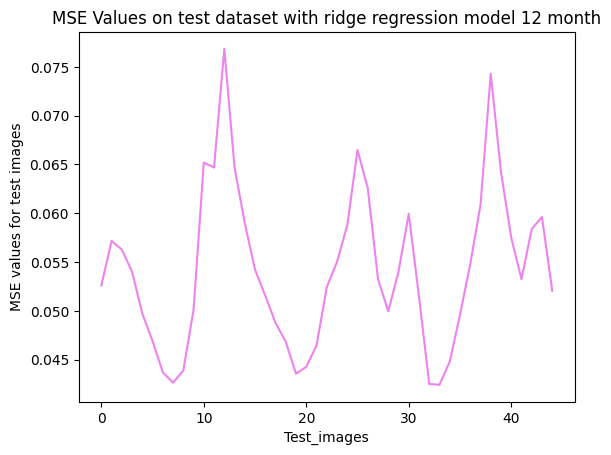

In [18]:
# R2_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/R2_ridge_score_LR_total.npy")
# error_ridge = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MAE_for_LR_total.npy")
# MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model 6 month output total/MSE_for_LR_total.npy")
# print(error_ridge)
plt.plot(R2_xgb_12)
plt.xlabel("Test_images")
plt.ylabel("R2 scores for test images")
plt.title("R2 Score Values on test dataset with ridge regression model 12 month")
plt.show()
plt.plot(error_xgb_12,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ridge regression model 12 month")
plt.show()
plt.plot(MSE_xgb_12, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ridge regression model 12 month")
#plt.legend(["MAE","MSE"])
plt.show()

In [19]:
np.mean(R2_xgb_12), np.max(R2_xgb_12), np.mean(MSE_xgb_12), np.mean(error_xgb_12)

(0.11210636728305477,
 0.25250376430649535,
 0.05423641930809253,
 0.21214674100540812)

LSTM

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [23]:
look_back = 1
model = Sequential()
model.add(LSTM(32),input_shape = (192,128,1))
model.add(LSTM(256))
model.add(LSTM(512))
model.add(LSTM(512))
model.add(LSTM(1024))
model.add(Dense(24576))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

TypeError: add() got an unexpected keyword argument 'input_shape'